## Installation

In [ ]:
!pip install google-cloud-bigquery-storage
!pip instal geopandas
!conda install -c plotly plotly

In [20]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [6]:
!bq query --use_legacy_sql=false --format=csv \
'SELECT start_station_name, count(trip_id) as Number_trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
where subscriber_type = "Customer" \
group by start_station_name \
order by Number_trips desc \
limit 20' > results3_start.csv 

Waiting on bqjob_r5045dd459fcffe1f_00000179b45724f7_1 ... (0s) Current status: DONE   


In [22]:
!bq query --use_legacy_sql=false --format=csv \
'SELECT distinct Station.latitude, Station.longitude, Station.landmark \
FROM `bigquery-public-data.san_francisco.bikeshare_stations` as Station \
join `bigquery-public-data.san_francisco.bikeshare_trips` as Trips \
on Trips.start_station_id=Station.station_id \
WHERE Trips.start_station_name in \
(SELECT start_station_name  FROM `bigquery-public-data.san_francisco.bikeshare_trips`\
where subscriber_type = "Customer"  \
group by start_station_name \
order by count(trip_id) desc \
limit 20)' > results3_coord_start.csv 

Waiting on bqjob_r300335409f5afb03_00000179b46152d7_1 ... (1s) Current status: DONE   


In [9]:
%%time
cust_start = pd.read_csv('results3_start.csv')
coord_start = pd.read_csv('results3_coord_start.csv')
coord_start

CPU times: user 10.8 ms, sys: 481 µs, total: 11.3 ms
Wall time: 35.4 ms


,latitude,longitude,landmark
0,37.795001,-122.399970,San Francisco
1,37.799953,-122.398525,San Francisco
2,37.787152,-122.388013,San Francisco
3,37.804770,-122.403234,San Francisco
4,37.781752,-122.405127,San Francisco
5,37.797900,-122.405942,San Francisco
6,37.791464,-122.391034,San Francisco
7,37.784878,-122.401014,San Francisco
8,37.776617,-122.395260,San Francisco
9,37.788446,-122.408499,San Francisco


In [24]:
%%bigquery coord_start
SELECT 
    distinct Station.latitude, 
    Station.longitude, 
    Station.station_id,
    count(Trips.trip_id) as Total_trips
FROM 
    `bigquery-public-data.san_francisco.bikeshare_stations` as Station 
join 
    `bigquery-public-data.san_francisco.bikeshare_trips` as Trips on Trips.start_station_id=Station.station_id
WHERE 
    Trips.start_station_name in 
    (SELECT 
         start_station_name  
    FROM 
         `bigquery-public-data.san_francisco.bikeshare_trips` 
    WHERE 
         subscriber_type = "Customer"  
    GROUP BY 
         start_station_name 
    ORDER BY 
         count(trip_id) desc limit 20)
GROUP BY
    Station.latitude,
    Station.longitude,
    Station.station_id

Downloading: 100%|██████████| 20/20 [00:01<00:00, 12.95rows/s]


In [25]:
# coord_start.set_index('station_id', inplace=True)
coord_start

,latitude,longitude,station_id,Total_trips
0,37.781752,-122.405127,57,18962
1,37.786305,-122.404966,76,27502
2,37.776619,-122.417385,67,30209
3,37.780526,-122.390288,61,39936
4,37.795001,-122.399970,41,14351
5,37.789625,-122.400811,77,35142
6,37.794139,-122.394434,74,38531
7,37.783871,-122.408433,39,25204
8,37.787152,-122.388013,54,22525
9,37.791464,-122.391034,51,21874


## GeoPandas

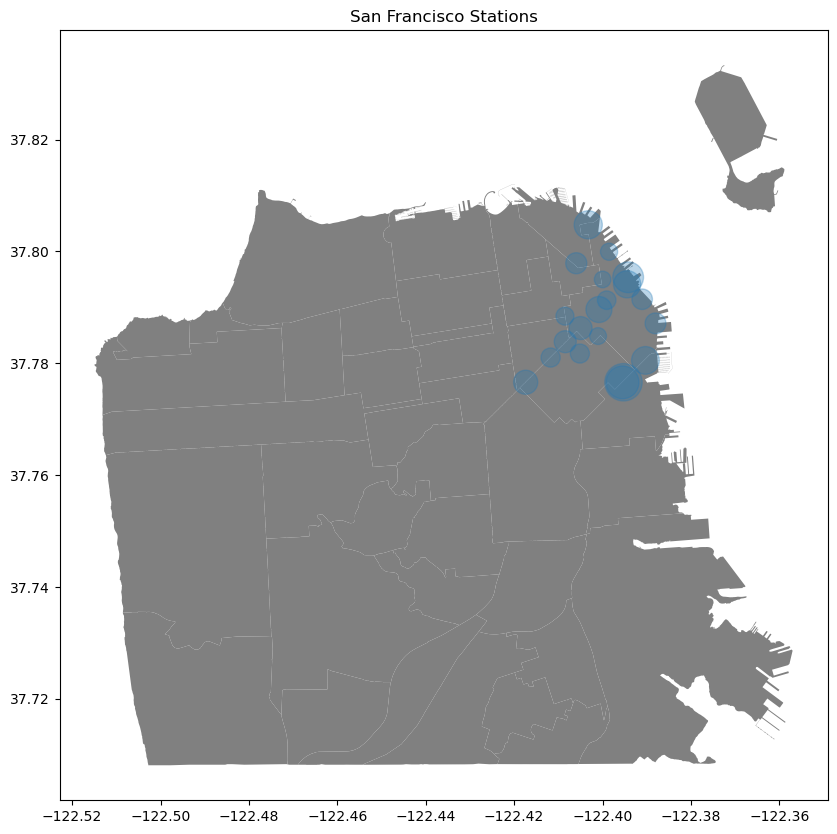

In [21]:
# Read the neighborhoods
sf = gpd.read_file("Analysis Neighborhoods.geojson")
sf = sf.rename(columns={'geometry': 'geometry','nhood':'neighborhood_name'}).set_geometry('geometry')

# Set up the data for plotting
coord_start['geometry'] = coord_start.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
crs = {'init': 'epsg:4326'}
data = gpd.GeoDataFrame(coord_start, crs=crs, geometry = 'geometry')

# Plot the 2 things together
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
data.plot(ax=sf_map, marker="o", markersize=data['Total_trips']/100, alpha=0.3)
ax.set_title("San Francisco Stations")
plt.show()

## Plotly

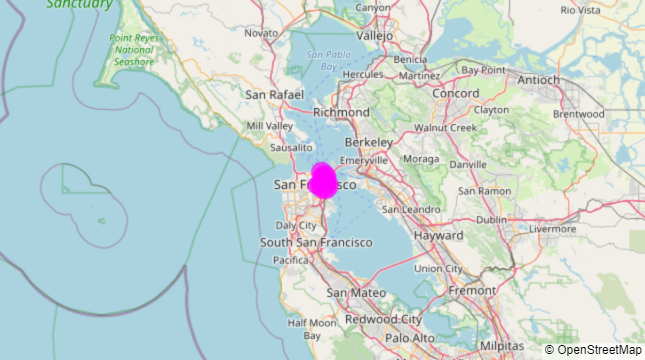

In [26]:
import plotly.express as px

fig = px.scatter_mapbox(coord_start, lat="latitude", lon="longitude", hover_name="station_id", hover_data=["Total_trips"],
                        color_discrete_sequence=["fuchsia"], height=300, size=coord_start['Total_trips']/100)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [27]:
%ls

'Analysis Neighborhoods.geojson'   async-videos.md            reveal.js@
 Dockerfile.test                   docker-compose.yml         sync-slides.md
 Example_GeoPandas.ipynb           images@                    sync-slides.pdf
 Makefile@                         results3_coord_start.csv
 README.md                         results3_start.csv
